In [1]:
from pynq.overlays.base import BaseOverlay
# base = BaseOverlay("base.bit")
# base = BaseOverlay("/home/xilinx/temp/base_wrapper.bit", download=False)
# base = BaseOverlay("/home/xilinx/temp/base_wrapper.bit")

# base = BaseOverlay(bitfile='/home/xilinx/dist/base_wrapper.bit', dtbo='/home/xilinx/dist/base_wrapper.dtbo', download=True)
base = BaseOverlay(bitfile='/home/xilinx/pynq_audio_dsp/base_wrapper.bit', dtbo='/home/xilinx/pynq_audio_dsp/base_wrapper.dtbo', download=True)

In [2]:
print(base.device.ip_dict['audio_codec_ctrl_0'])
print(base.device.ip_dict['pynq_dsp_hls_0'])

print(hex(base.device.ip_dict['audio_codec_ctrl_0']['phys_addr']))
print(hex(base.device.ip_dict['pynq_dsp_hls_0']['phys_addr']))
print(hex(base.audio.mmio.base_addr))

{'fullpath': 'audio_codec_ctrl_0', 'type': 'xilinx.com:user:audio_codec_ctrl:1.0', 'state': None, 'addr_range': 65536, 'phys_addr': 1136656384, 'mem_id': 'S_AXI', 'gpio': {}, 'interrupts': {}, 'parameters': {'C_S_AXI_DATA_WIDTH': '32', 'C_S_AXI_ADDR_WIDTH': '32', 'C_S_AXI_MIN_SIZE': '0x000001FF', 'C_USE_WSTRB': '0', 'C_DPHASE_TIMEOUT': '8', 'C_FAMILY': 'zynq', 'C_NUM_REG': '1', 'C_NUM_MEM': '1', 'C_SLV_AWIDTH': '32', 'C_SLV_DWIDTH': '32', 'C_CODEC_ADDRESS': '"11"', 'Component_Name': 'base_audio_codec_ctrl_0_0', 'EDK_IPTYPE': 'PERIPHERAL', 'C_BASEADDR': '0x43C00000', 'C_HIGHADDR': '0x43C0FFFF'}, 'registers': {}}
{'fullpath': 'pynq_dsp_hls_0', 'type': 'kamiyaowl:hls:pynq_dsp_hls:0.2', 'state': None, 'addr_range': 65536, 'phys_addr': 1137180672, 'mem_id': 's_axi_AXILiteS', 'gpio': {}, 'interrupts': {'interrupt': {'controller': 'system_interrupts', 'index': 16, 'fullpath': 'pynq_dsp_hls_0/interrupt'}}, 'parameters': {'C_S_AXI_AXILITES_ADDR_WIDTH': '7', 'C_S_AXI_AXILITES_DATA_WIDTH': '32', 

In [3]:
# Line入力を有効化
pAudio = base.audio
pAudio.select_line_in() # line入力を使う

# 自作HLSライブラリを設定する
dsp = base.pynq_dsp_hls_0
offset_basePhyisAddr = dsp.register_map.basePhysAddr_V.address
offset_ctrl          = dsp.register_map.CTRL.address
offset_config        = dsp.register_map.Memory_configReg.address
config_stage_size    = 4 # word
config_num_of_stage  = 4

    
# HLSのAXI4Slave Regの状態を表示する
def print_status():
    print('=== status ===')
    print('ctrl', hex(offset_ctrl), hex(dsp.read(offset=offset_ctrl)))
    print('basePhysAddr', hex(offset_basePhyisAddr), hex(dsp.read(offset=offset_basePhyisAddr)))
    for stageIndex in range(0, config_num_of_stage):
        for regIndex in range(0, config_stage_size):
            addr = offset_config + ((config_stage_size * stageIndex) + regIndex) * 4
            print('config[', stageIndex, '][', regIndex, ']', hex(addr), hex(dsp.read(offset=addr)))
    
print_status()

# Bypassの読み書きのベースアドレスを指定
dsp.write(offset=offset_basePhyisAddr, value=pAudio.mmio.base_addr)
# HLSのモジュールを開始させる
dsp.write(offset=offset_ctrl, value=0x81) # AUTO_RESTART, AP_START

print_status()

=== status ===
ctrl 0x0 0x4
basePhysAddr 0x10 0x0
config[ 0 ][ 0 ] 0x40 0x0
config[ 0 ][ 1 ] 0x44 0x0
config[ 0 ][ 2 ] 0x48 0x0
config[ 0 ][ 3 ] 0x4c 0x0
config[ 1 ][ 0 ] 0x50 0x0
config[ 1 ][ 1 ] 0x54 0x0
config[ 1 ][ 2 ] 0x58 0x0
config[ 1 ][ 3 ] 0x5c 0x0
config[ 2 ][ 0 ] 0x60 0x0
config[ 2 ][ 1 ] 0x64 0x0
config[ 2 ][ 2 ] 0x68 0x0
config[ 2 ][ 3 ] 0x6c 0x0
config[ 3 ][ 0 ] 0x70 0x0
config[ 3 ][ 1 ] 0x74 0x0
config[ 3 ][ 2 ] 0x78 0x0
config[ 3 ][ 3 ] 0x7c 0x0
=== status ===
ctrl 0x0 0x83
basePhysAddr 0x10 0x43c00000
config[ 0 ][ 0 ] 0x40 0x0
config[ 0 ][ 1 ] 0x44 0x0
config[ 0 ][ 2 ] 0x48 0x0
config[ 0 ][ 3 ] 0x4c 0x0
config[ 1 ][ 0 ] 0x50 0x0
config[ 1 ][ 1 ] 0x54 0x0
config[ 1 ][ 2 ] 0x58 0x0
config[ 1 ][ 3 ] 0x5c 0x0
config[ 2 ][ 0 ] 0x60 0x0
config[ 2 ][ 1 ] 0x64 0x0
config[ 2 ][ 2 ] 0x68 0x0
config[ 2 ][ 3 ] 0x6c 0x0
config[ 3 ][ 0 ] 0x70 0x0
config[ 3 ][ 1 ] 0x74 0x0
config[ 3 ][ 2 ] 0x78 0x0
config[ 3 ][ 3 ] 0x7c 0x0


In [32]:
# HLS Libのコンフィグに4byte書き込みます
def write_dsp_config(stageIndex, offsetIndex, val):
    addr = offset_config + (((config_stage_size * stageIndex) + offsetIndex)) * 4
    print('Write:', hex(addr), '<=', val)
    dsp.write(offset=addr, value=val)

# floatのbitpatternをそのままuint32に変換します
import struct
def float_to_uint32(float_val):
    return int.from_bytes(bytearray(struct.pack(">f", float_val)), 'big') # 4byte内での復元なのでbigでよい

#EffectIdをBypass->Distortionに切り替える
write_dsp_config(0, 0, 1)
#write_dsp_config(0, 1, 0x3dcccccd)
write_dsp_config(0, 1, float_to_uint32(0.1))
print_status()


Write: 0x40 <= 1
Write: 0x44 <= 1036831949
=== status ===
ctrl 0x0 0x83
basePhysAddr 0x10 0x43c00000
config[ 0 ][ 0 ] 0x40 0x1
config[ 0 ][ 1 ] 0x44 0x3dcccccd
config[ 0 ][ 2 ] 0x48 0x0
config[ 0 ][ 3 ] 0x4c 0x0
config[ 1 ][ 0 ] 0x50 0x0
config[ 1 ][ 1 ] 0x54 0x0
config[ 1 ][ 2 ] 0x58 0x0
config[ 1 ][ 3 ] 0x5c 0x0
config[ 2 ][ 0 ] 0x60 0x0
config[ 2 ][ 1 ] 0x64 0x0
config[ 2 ][ 2 ] 0x68 0x0
config[ 2 ][ 3 ] 0x6c 0x0
config[ 3 ][ 0 ] 0x70 0x0
config[ 3 ][ 1 ] 0x74 0x0
config[ 3 ][ 2 ] 0x78 0x0
config[ 3 ][ 3 ] 0x7c 0x0


In [ ]:
# Auto Restartを切ってみる
dsp.write(offset=offset_ctrl, value=0x00) # AUTO_RESTART, AP_START
print_status()

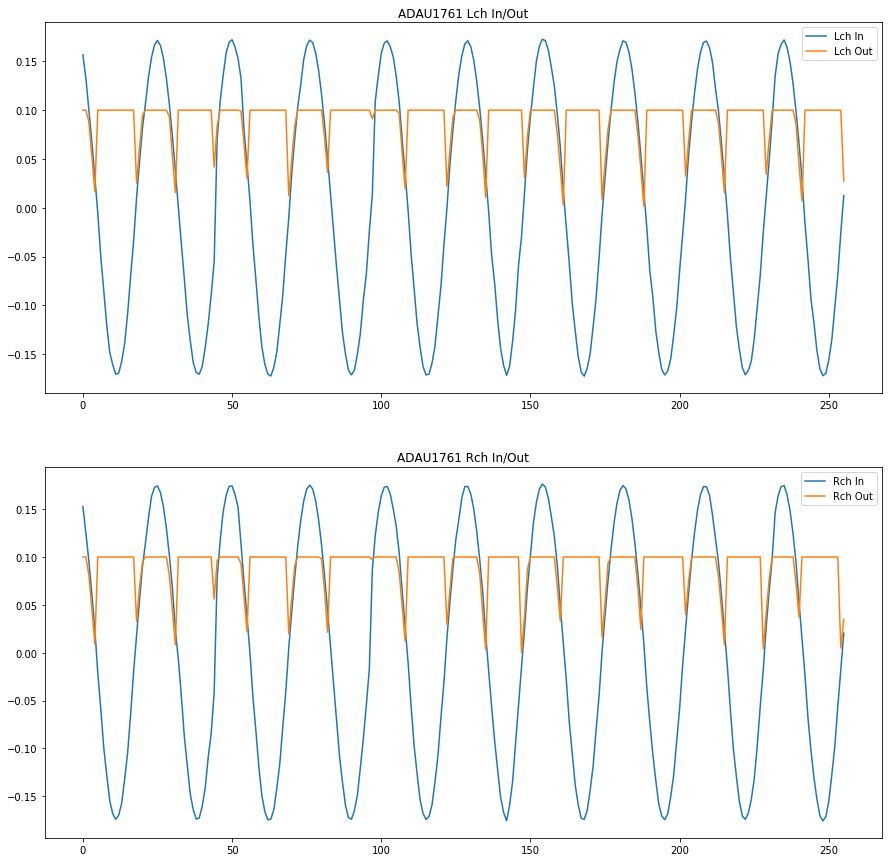

In [33]:
n_samples = 256

# あとでグラフに書きたい
l_src_arr = []
r_src_arr = []
l_dst_arr = []
r_dst_arr = []

# from audio_adau1761.h
I2S_DATA_RX_L_REG = 0x00
I2S_DATA_RX_R_REG = 0x04
I2S_DATA_TX_L_REG = 0x08
I2S_DATA_TX_R_REG = 0x0C
I2S_STATUS_REG    = 0x10

# 24bit 2の補数表現がおかしく変換されるのでもとに戻す
def int24_to_int(src):
    if ((src >> 23) & 0x1) == 0x1:
        # 負数 24bitまでを反転させて1を足す
        return -(((~src) & 0xffffff) + 1)
    else:
        # 正の数
        return src

        return (threash + diff)

for i in range(0, n_samples):
    # 音声の取得
    l_src = int24_to_int(pAudio.mmio.read_reg(offset=I2S_DATA_RX_L_REG))/0x7fffff
    r_src = int24_to_int(pAudio.mmio.read_reg(offset=I2S_DATA_RX_R_REG))/0x7fffff
    l_dst = int24_to_int(pAudio.mmio.read_reg(offset=I2S_DATA_TX_L_REG))/0x7fffff
    r_dst = int24_to_int(pAudio.mmio.read_reg(offset=I2S_DATA_TX_R_REG))/0x7fffff
    # グラフ書くために残す
    l_src_arr.append(l_src)
    r_src_arr.append(r_src)
    l_dst_arr.append(l_dst)
    r_dst_arr.append(r_dst)
    
    
# さっき取得したデータのグラフを書く
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 15.0)
from ipywidgets import *

plt.subplot(2,1,1)
plt.title('ADAU1761 Lch In/Out')
plt.plot(l_src_arr, label='Lch In')
plt.plot(l_dst_arr, label='Lch Out')
plt.legend()
plt.subplot(2,1,2)
plt.title('ADAU1761 Rch In/Out')
plt.plot(r_src_arr, label='Rch In')
plt.plot(r_dst_arr, label='Rch Out')
plt.legend()
plt.show()